# Text Sentiment Analysis of IMDB Movie reviews using NLP (Word2Vec and RNN) for MYM Intern Assesment

## Assesment Objectives: 
### - Preprocessing the data
### - Converting Text(words) to Vectors using word2vec 
### - Using the word representations given by word2vec to feed a RNN and training the model
### - Evaluating the model
### - Testing the model


In [1]:
!pip freeze | grep gensim ##Checking the version of Gensim - Word2Vec

gensim==4.2.0


## The Data

### Starting with 20% of the sentences from TensorFlow Datasets of IMDB reviews to check the RAM compatibility of the PC to train the model faster by splitting the datasets as X_train, y_train, X_test and y_test.
### Then preprocessing the textual data to create input features for a natural language processing (NLP) model.



In [2]:
import numpy as np
import pandas as pd
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.text import text_to_word_sequence

def load_data(percentage_of_sentences=None):
    train_data, test_data = tfds.load(name="imdb_reviews", split=["train", "test"], batch_size=-1, as_supervised=True)

    train_sentences, y_train = tfds.as_numpy(train_data)
    test_sentences, y_test = tfds.as_numpy(test_data)
    
    # Take only a given percentage of the entire data
    if percentage_of_sentences is not None:
      assert(percentage_of_sentences> 0 and percentage_of_sentences<=100)
        
      len_train = int(percentage_of_sentences/100*len(train_sentences))
      train_sentences, y_train = train_sentences[:len_train], y_train[:len_train]
  
      len_test = int(percentage_of_sentences/100*len(test_sentences))
      test_sentences, y_test = test_sentences[:len_test], y_test[:len_test]
    
    X_train = [text_to_word_sequence(_.decode("utf-8")) for _ in train_sentences]
    X_test = [text_to_word_sequence(_.decode("utf-8")) for _ in test_sentences]
    
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = load_data(percentage_of_sentences=20)

2023-05-02 10:34:53.357804: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [3]:
y_test

array([1, 1, 0, ..., 1, 0, 0])

## First, training a word2vec model (with the arguments that we want) on your training sentence. Store it into the `word2vec` variable. 

In [46]:
from gensim.models import Word2Vec

word2vec = Word2Vec(sentences=X_train, vector_size=60, min_count=10, window=10)
word2vec.save("word2vec.model")



## Embedding the training and test sentences.

In [5]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Function to convert a sentence (list of words) into a matrix representing the words in the embedding space
def embed_sentence(word2vec, sentence):
    embedded_sentence = []
    for word in sentence:
        if word in word2vec.wv:
            embedded_sentence.append(word2vec.wv[word])
        
    return np.array(embedded_sentence)

# Function that converts a list of sentences into a list of matrices
def embedding(word2vec, sentences):
    embed = []
    
    for sentence in sentences:
        embedded_sentence = embed_sentence(word2vec, sentence)
        embed.append(embedded_sentence)
        
    return embed

# Embed the training and test sentences
X_train_embed = embedding(word2vec, X_train)
X_test_embed = embedding(word2vec, X_test)


# Pad the training and test embedded sentences
X_train_pad = pad_sequences(X_train_embed, dtype='float32', padding='post', maxlen=200)
X_test_pad = pad_sequences(X_test_embed, dtype='float32', padding='post', maxlen=200)

### It's a good practice to check check the following for `X_train_pad` and `X_test_pad`:
#### - they are numpy arrays
#### - they are 3-dimensional
#### - the last dimension is of the size of your word2vec embedding space (you can get it with `word2vec.wv.vector_size`\\
#### - the first dimension is of the size of your `X_train` and `X_test`

In [6]:
for X in [X_train_pad, X_test_pad]:
    assert type(X) == np.ndarray
    assert X.shape[-1] == word2vec.wv.vector_size


assert X_train_pad.shape[0] == len(X_train)
assert X_test_pad.shape[0] == len(X_test)

## Baseline Model

In [7]:
# It is always good to have a very simple model to test your own model against
# Baseline accuracy can be to predict the label that is the most present in `y_train`.
from sklearn.metrics import accuracy_score

unique, counts = np.unique(y_train, return_counts=True)
counts = dict(zip(unique, counts))
print('Number of labels in train set', counts)

y_pred = 0 if counts[0] > counts[1] else 1

print('Baseline accuracy: ', accuracy_score(y_test, [y_pred]*len(y_test)))

Number of labels in train set {0: 2474, 1: 2526}
Baseline accuracy:  0.499


## The Model

In [32]:
from tensorflow.keras import Sequential
from tensorflow.keras import layers

# writing a RNN model with Masking, LSTM and Dense layers.

def init_model():
    model = Sequential()
    model.add(layers.Masking())
    model.add(layers.LSTM(20, activation='tanh'))
    model.add(layers.Dense(15, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', #compiling the model with rmsprop optimizer
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    
    return model

model = init_model()

In [33]:
#  Fiting the model on embedded and padded data with the early stopping criterion.

from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(X_train_pad, y_train, 
          batch_size = 32,
          epochs=100,
          validation_split=0.3,
          callbacks=[es]
         )

Epoch 1/100
110/110 [==============================] - 7s 37ms/step - loss: 0.6816 - accuracy: 0.5657 - val_loss: 0.6784 - val_accuracy: 0.5820
Epoch 2/100
110/110 [==============================] - 4s 32ms/step - loss: 0.6378 - accuracy: 0.6414 - val_loss: 0.6497 - val_accuracy: 0.6220
Epoch 3/100
110/110 [==============================] - 4s 32ms/step - loss: 0.5893 - accuracy: 0.6894 - val_loss: 0.6029 - val_accuracy: 0.6780
Epoch 4/100
110/110 [==============================] - 4s 32ms/step - loss: 0.5411 - accuracy: 0.7246 - val_loss: 0.5643 - val_accuracy: 0.7187
Epoch 5/100
110/110 [==============================] - 3s 32ms/step - loss: 0.5107 - accuracy: 0.7494 - val_loss: 0.5413 - val_accuracy: 0.7347
Epoch 6/100
110/110 [==============================] - 4s 32ms/step - loss: 0.4852 - accuracy: 0.7680 - val_loss: 0.5275 - val_accuracy: 0.7493
Epoch 7/100
110/110 [==============================] - 4s 32ms/step - loss: 0.4592 - accuracy: 0.7846 - val_loss: 0.5303 - val_accuracy:

In [34]:
# Evaluating the model on the test set.

result = model.evaluate(X_test_pad, y_test, verbose=0)

print(f'The accuracy evaluated on the test set is of {result[1]*100:.3f}%')

The accuracy evaluated on the test set is of 77.900%


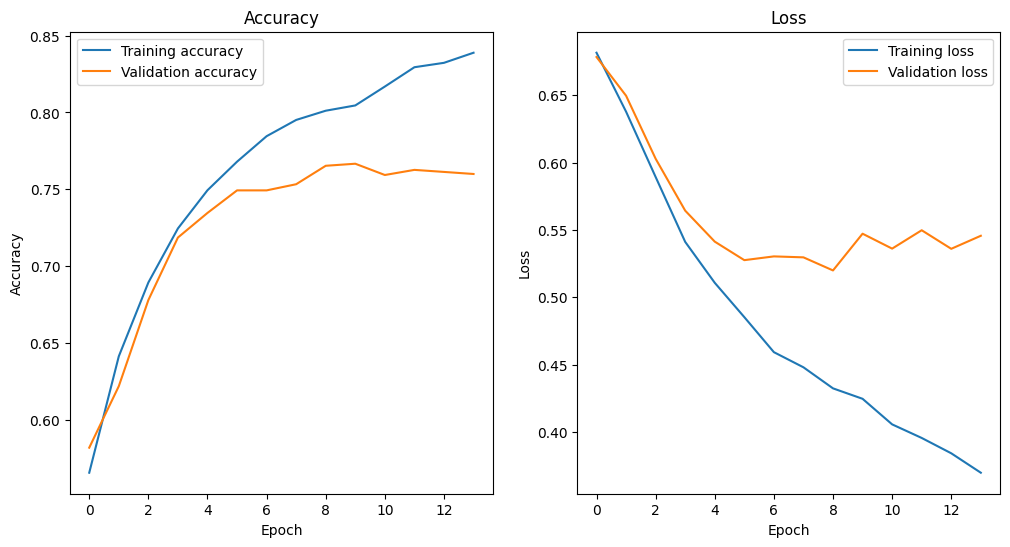

In [35]:
import matplotlib.pyplot as plt

# Plot the accuracy and loss curves
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Trained Word2Vec - Transfer Learning


### The accuracy of the above the baseline model, might be quite low. By improving the quality of the embedding we can Improve accuracy of the model.

### Let's improve the quality of our embedding, instead of just loading a larger corpus, let's benefit from the embedding that others have learned. Because, the quality of an embedding, i.e. the proximity of the words, can be derived from different tasks. This is exactly what transfer learning is.

### Listing all the different models available in the word2vec using gensim api.

In [36]:
import gensim.downloader as api
print(list(api.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [37]:
#Let's load one of the pre-trained word2vec embedding spaces. 

word2vec_transfer = api.load("glove-wiki-gigaword-100")

In [39]:
print(len(word2vec_transfer.key_to_index))
print(len(word2vec_transfer['dog']))

400000
100


In [40]:
# Function to convert a sentence (list of words) into a matrix representing the words in the embedding space
def embed_sentence_with_TF(word2vec, sentence):
    embedded_sentence = []
    for word in sentence:
        if word in word2vec:
            embedded_sentence.append(word2vec[word])
        
    return np.array(embedded_sentence)

# Function that converts a list of sentences into a list of matrices
def embedding(word2vec, sentences):
    embed = []
    
    for sentence in sentences:
        embedded_sentence = embed_sentence_with_TF(word2vec, sentence)
        embed.append(embedded_sentence)
        
    return embed

# Embed the training and test sentences
X_train_embed_2 = embedding(word2vec_transfer, X_train)
X_test_embed_2 = embedding(word2vec_transfer, X_test)

In [41]:
# Pad the training and test embedded sentences
X_train_pad_2 = pad_sequences(X_train_embed_2, dtype='float32', padding='post', maxlen=200)
X_test_pad_2 = pad_sequences(X_test_embed_2, dtype='float32', padding='post', maxlen=200)

In [42]:
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

es = EarlyStopping(patience=5, restore_best_weights=True)

model = init_model()

history = model.fit(X_train_pad_2, y_train, 
          batch_size = 32,
          epochs=30,
          validation_split=0.3,
          callbacks=[es]
         )
model.save('my_model.h5')


Epoch 1/30
110/110 [==============================] - 7s 40ms/step - loss: 0.6818 - accuracy: 0.5517 - val_loss: 0.6643 - val_accuracy: 0.6067
Epoch 2/30
110/110 [==============================] - 4s 35ms/step - loss: 0.6205 - accuracy: 0.6563 - val_loss: 0.7295 - val_accuracy: 0.5533
Epoch 3/30
110/110 [==============================] - 4s 34ms/step - loss: 0.5744 - accuracy: 0.7100 - val_loss: 0.7012 - val_accuracy: 0.6093
Epoch 4/30
110/110 [==============================] - 4s 35ms/step - loss: 0.5473 - accuracy: 0.7251 - val_loss: 0.6028 - val_accuracy: 0.6673
Epoch 5/30
110/110 [==============================] - 4s 35ms/step - loss: 0.5206 - accuracy: 0.7477 - val_loss: 0.5299 - val_accuracy: 0.7413
Epoch 6/30
110/110 [==============================] - 4s 35ms/step - loss: 0.4944 - accuracy: 0.7720 - val_loss: 0.5602 - val_accuracy: 0.7220
Epoch 7/30
110/110 [==============================] - 4s 34ms/step - loss: 0.4740 - accuracy: 0.7834 - val_loss: 0.4964 - val_accuracy: 0.7693

In [43]:
result = model.evaluate(X_test_pad_2, y_test, verbose=0)

print(f'The accuracy evaluated on the test set is of {result[1]*100:.3f}%')

The accuracy evaluated on the test set is of 81.580%


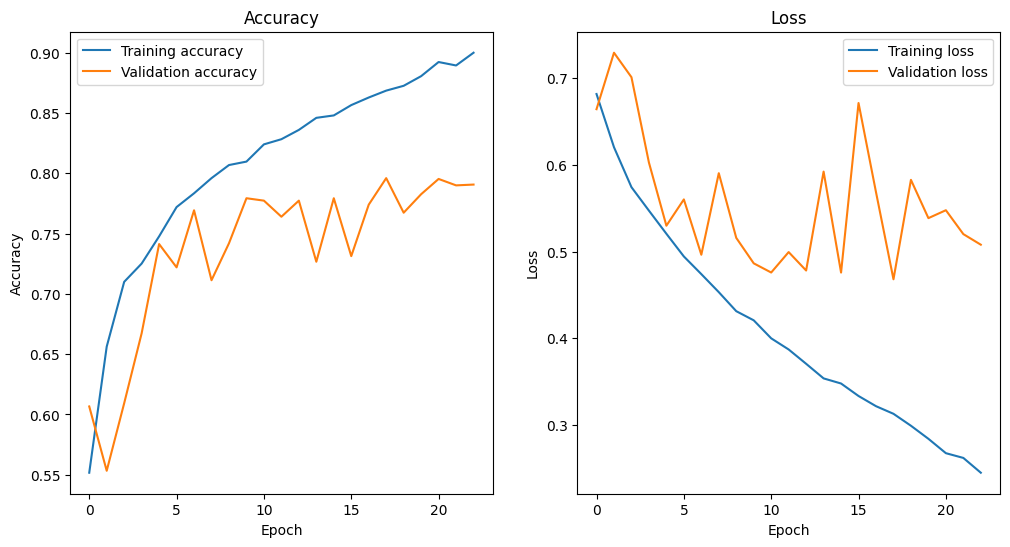

In [44]:
# Plot the accuracy and loss curves
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

### There is a significant improvement in the accuracy after Transfer learning.

## Testing the model for new review.

In [61]:
import numpy as np
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model

# Load the trained model and its dependencies
word2vec = Word2Vec.load('word2vec.model')
model = load_model('my_model.h5')

# Load the new movie review to test
new_review = "I loved this movie!."

# Preprocess the new review
new_review = text_to_word_sequence(new_review)
new_review_embed = []
for word in new_review:
    if word in word2vec.wv:
        word_embed = word2vec.wv[word]
        # Pad the word embedding to ensure it has length 100
        word_embed = word_embed[:100] if len(word_embed) > 100 else np.pad(word_embed, (0, 100 - len(word_embed)))
        new_review_embed.append(word_embed)
new_review_pad = pad_sequences([new_review_embed], dtype='float32', padding='post', maxlen=200, truncating='post')

# Predict the sentiment of the new review
predicted_label = model.predict(new_review_pad)[0][0]
if predicted_label == 1:
    print("Positive review")
else:
    print("Negative review")



1/1 [==============================] - 1s 1s/step
Negative review


In [49]:
!git add Sentiment_Analysis_using_NLP.ipynb

In [50]:
!git commit -m 'Sentiment Analysis using NLP'

[master 8b90098] Sentiment Analysis using NLP
 1 file changed, 234 insertions(+), 133 deletions(-)


In [52]:
!git push origin master

Everything up-to-date
